In [66]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm

from numba import njit

In [67]:
def init_lattice(L):
    return np.random.choice([-1,1], size = (L,L))

In [68]:
@njit(cache = True)
def dE(s, i, j, L, J):
    t = s[i - 1 if i>0 else L-1, j]
    b = s[i + 1 if i<L-1 else 0, j]
    l = s[i, j - 1 if j>0 else L-1]
    r = s[i, j + 1 if j<L-1 else 0]

    return J * 2 * (t + b + l + r) * s[i, j]

In [69]:
@njit(cache = True, fastmath = True)
def MonterCarlo_move(s, L, J):
    for _ in range(L*L):       
        i = np.random.randint(0,L)
        j = np.random.randint(0,L)
        ediff = dE(s,i,j,L, J)
        if ediff <= 0:
            s[i,j] = -s[i, j]
        elif np.random.random() < np.exp(-ediff):
            s[i,j] = -s[i, j]
    return s

In [70]:
@njit(cache = True, fastmath = True)
def Energy(s, L, J):
    energy = 0
    for i in range(L):
        for j in range(L):
            S = s[i, j]
            nn = s[(i+1)%L, j] + s[i,(j+1)%L] + s[(i-1)%L, j] + s[i,(j-1)%L]
            energy += -nn*S   
    return energy/4 #add/remove J


@njit(cache = True)
def Mag(s):
    mag = 0
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            mag += s[i, j]
    return mag


In [78]:
### Define algorithm parameters ###

temp_points = 100    # number of temperature points
L = 32              # lattice size
eq_limit = 50000    # Maximum iterations before equilibrum
mc_sweeps  = 10000  # Sweeps in Monte Carlo-sampling

T_list = np.linspace(0.5, 5, temp_points)        #change to real Boltzman constant if necessary
J_list = 1/(T_list)

s = init_lattice(L)
E, M = np.zeros(temp_points), np.zeros(temp_points)
CV ,X = np.zeros(temp_points), np.zeros(temp_points)
 

In [79]:

def equilibriate(s, L, J, max_sweeps,stable_blocks = 5, block_size = 100, tol = 1e-4):
    N = L*L
    prev_block_avg = None
    stable_count = 0

    count = 0
    while count < max_sweeps:
        E_block = 0
        for _ in range(block_size):
            MonterCarlo_move(s,L,J)
            E_block += Energy(s, L, J) / N
            
        block_avg = E_block/block_size

        if prev_block_avg is not None:
            if abs(block_avg - prev_block_avg) < tol:
                stable_count += 1
                if stable_count >= stable_blocks:
                    print(f'Achieved stable count at {count}')
                    break
            else:
                stable_count = 0
        
        prev_block_avg = block_avg
        count += block_size
    
    return count

In [80]:
def main():
    for n, J in tqdm(enumerate(J_list), total=len(J_list), desc="J loop"):   
        s = init_lattice(L)
        E_j = M_j = 0
        E2_j = M2_j = 0

        equilibriate(s, L, J, eq_limit)
        
        for _ in range(mc_sweeps):
            MonterCarlo_move(s,L,J)
            E_sample = Energy(s, L, J)
            M_sample = Mag(s)
        
            E_j += E_sample
            M_j += abs(M_sample)
            E2_j += E_sample*E_sample
            M2_j += M_sample*M_sample
        T = T_list[n]
        E[n] = E_j/(mc_sweeps*L*L)
        M[n] = M_j/(mc_sweeps*L*L)
        CV[n] = (E2_j - E_j*E_j/mc_sweeps)/(mc_sweeps*L*L*T*T) 
        X[n] = (M2_j- M_j*M_j/mc_sweeps)/(mc_sweeps*L*L*T) 

In [81]:
main()


J loop:   9%|▉         | 7/80 [00:00<00:02, 29.75it/s]

Achieved stable count at 600
Achieved stable count at 700
Achieved stable count at 700


J loop: 100%|██████████| 80/80 [00:03<00:00, 21.55it/s]


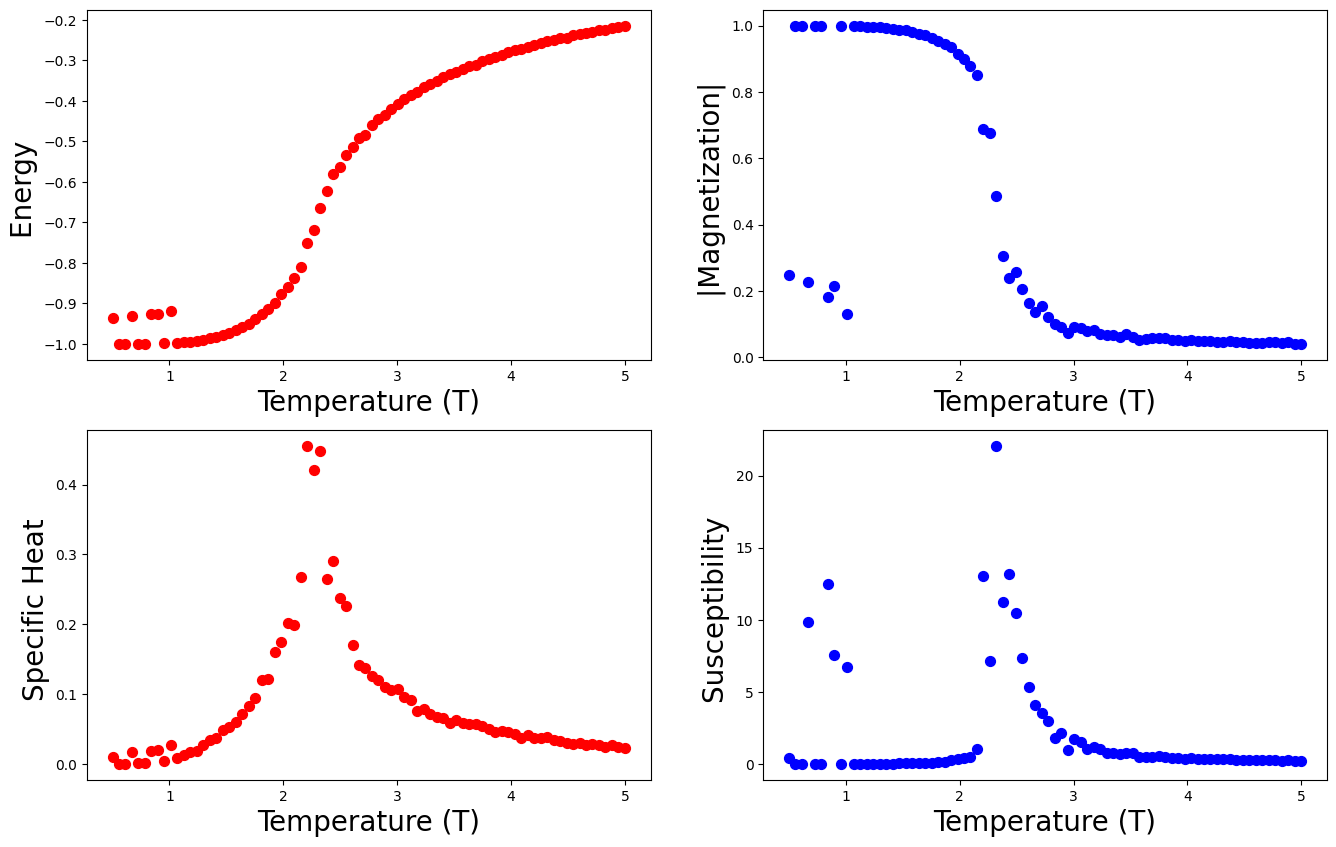

In [82]:
f = plt.figure(figsize=(16,10))


sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T_list, E, s=50, color='Red')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2);
plt.scatter(T_list, M, s=50, color='Blue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("|Magnetization| ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T_list, CV, s=50, color='Red')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T_list, X, s=50, color='Blue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Susceptibility ", fontsize=20);         plt.axis('tight');

# plt.savefig(f'figs/Task1_{L}x{L}')